In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

from loader import train_loader, val_loader, test_loader, scaler
from models.dcf import DistributionalConditionalForecast, dcf_loss

In [ ]:
model = DistributionalConditionalForecast(
    window_size=30, 
	num_series=2, 
	static_dim=18,
    latent_dim=32, 
	hidden_dim=128,
    dropout=0.1, 
	output_dim=2
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [3]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
kl_start = 0.0
kl_max = 0.001

In [4]:
epochs = 100
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    # KL annealing
    kl_weight = min(0.001, 0.001 * (epoch / 50))  # Từ 0 -> 0.001 dần dần
    
    for x_seq, x_cal, y in train_loader:
        x_seq = x_seq.to(device)
        x_cal = x_cal.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        out, mu_z, logvar_z = model(x_seq, x_cal)
        loss = dcf_loss(out, y, mu_z, logvar_z, kl_weight=kl_weight)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item() * x_seq.size(0)
    
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for x_seq, x_cal, y in val_loader:
            x_seq = x_seq.to(device)
            x_cal = x_cal.to(device)
            y = y.to(device)
            out, mu_z, logvar_z = model(x_seq, x_cal)
            loss = dcf_loss(out, y, mu_z, logvar_z, kl_weight=kl_weight)
            running_val_loss += loss.item() * x_seq.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    scheduler.step(epoch_val_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, KL Weight: {kl_weight:.6f}")
    
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        checkpoint = {
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': epoch_val_loss
        }
        torch.save(checkpoint, 'checkpoints/DCF.pth')
        print(f"Best model updated at epoch {epoch+1} with validation loss {epoch_val_loss:.4f}")

Best model updated at epoch 1 with validation loss 1.6730
Best model updated at epoch 2 with validation loss 1.3682
Best model updated at epoch 3 with validation loss 1.0955
Best model updated at epoch 4 with validation loss 0.7427
Best model updated at epoch 5 with validation loss 0.6541
Best model updated at epoch 6 with validation loss 0.4815
Best model updated at epoch 7 with validation loss 0.3945
Best model updated at epoch 8 with validation loss 0.3105
Best model updated at epoch 9 with validation loss 0.2762
Epoch [10/100], Train Loss: 0.0612, Val Loss: 0.2568, KL Weight: 0.000180
Best model updated at epoch 10 with validation loss 0.2568
Best model updated at epoch 13 with validation loss 0.2016
Best model updated at epoch 14 with validation loss 0.1682
Best model updated at epoch 15 with validation loss -0.0641
Best model updated at epoch 18 with validation loss -0.0944
Best model updated at epoch 19 with validation loss -0.1070
Epoch [20/100], Train Loss: -0.3822, Val Loss: 

In [5]:
model.eval()
all_mu = []
all_logvar = []
all_actuals = []
with torch.no_grad():
    for x_seq, x_cal, y in test_loader:
        x_seq = x_seq.to(device)
        x_cal = x_cal.to(device)
        y = y.to(device)
        out, mu_z, logvar_z = model(x_seq, x_cal)
        output_dim = out.shape[1] // 2
        mu_y = out[:, :output_dim]         # Predicted mean (scaled)
        logvar_y = out[:, output_dim:]     # Predicted log variance (scaled)
        all_mu.append(mu_y.cpu().numpy())
        all_logvar.append(logvar_y.cpu().numpy())
        all_actuals.append(y.cpu().numpy())

mu_preds = np.concatenate(all_mu, axis=0)         # Shape: (n_samples, output_dim)
logvar_preds = np.concatenate(all_logvar, axis=0)   # Shape: (n_samples, output_dim)
sigma_preds = np.exp(0.5 * logvar_preds)            # σ = exp(0.5*logvar)
actuals = np.concatenate(all_actuals, axis=0)

# Inverse transform predicted mean và actual:
mu_preds_inv = scaler.inverse_transform(mu_preds)
actuals_inv = scaler.inverse_transform(actuals)

# Chuyển đổi σ sang thang đo ban đầu: với StandardScaler, sigma_inv = sigma_pred * scale
sigma_preds_inv = sigma_preds * scaler.scale_

# Tính các khoảng tin cậy (95% và 90%) trên không gian đã scale
lower_95 = mu_preds - 1.96 * sigma_preds
upper_95 = mu_preds + 1.96 * sigma_preds
lower_90 = mu_preds - 1.645 * sigma_preds
upper_90 = mu_preds + 1.645 * sigma_preds

# Inverse transform các khoảng tin cậy:
lower_95_inv = scaler.inverse_transform(lower_95)
upper_95_inv = scaler.inverse_transform(upper_95)
lower_90_inv = scaler.inverse_transform(lower_90)
upper_90_inv = scaler.inverse_transform(upper_90)

r2 = r2_score(actuals_inv, mu_preds_inv)
mape = mean_absolute_percentage_error(actuals_inv, mu_preds_inv)
rmse = np.sqrt(mean_squared_error(actuals_inv, mu_preds_inv))

print(f"Test R-squared: {r2:.4f}")
print(f"Test MAPE: {mape:.4f}")
print(f"Test RMSE: {rmse:.4f}")

Test R-squared: 0.9650
Test MAPE: 0.2691
Test RMSE: 127062.2422


In [6]:
# Tính các chỉ số riêng cho Units và Revenue
r2_units = r2_score(actuals_inv[:, 0], mu_preds_inv[:, 0])
mape_units = mean_absolute_percentage_error(actuals_inv[:, 0], mu_preds_inv[:, 0])
rmse_units = np.sqrt(mean_squared_error(actuals_inv[:, 0], mu_preds_inv[:, 0]))

print(f"Test Units R-squared: {r2_units:.4f}")
print(f"Test Units MAPE: {mape_units:.4f}")
print(f"Test Units RMSE: {rmse_units:.4f}")

r2_revenue = r2_score(actuals_inv[:, 1], mu_preds_inv[:, 1])
mape_revenue = mean_absolute_percentage_error(actuals_inv[:, 1], mu_preds_inv[:, 1])
rmse_revenue = np.sqrt(mean_squared_error(actuals_inv[:, 1], mu_preds_inv[:, 1]))

print(f"Test Revenue R-squared: {r2_revenue:.4f}")
print(f"Test Revenue MAPE: {mape_revenue:.4f}")
print(f"Test Revenue RMSE: {rmse_revenue:.4f}")

Test Units R-squared: 0.9610
Test Units MAPE: 0.3068
Test Units RMSE: 25.5304
Test Revenue R-squared: 0.9689
Test Revenue MAPE: 0.2313
Test Revenue RMSE: 179693.0781


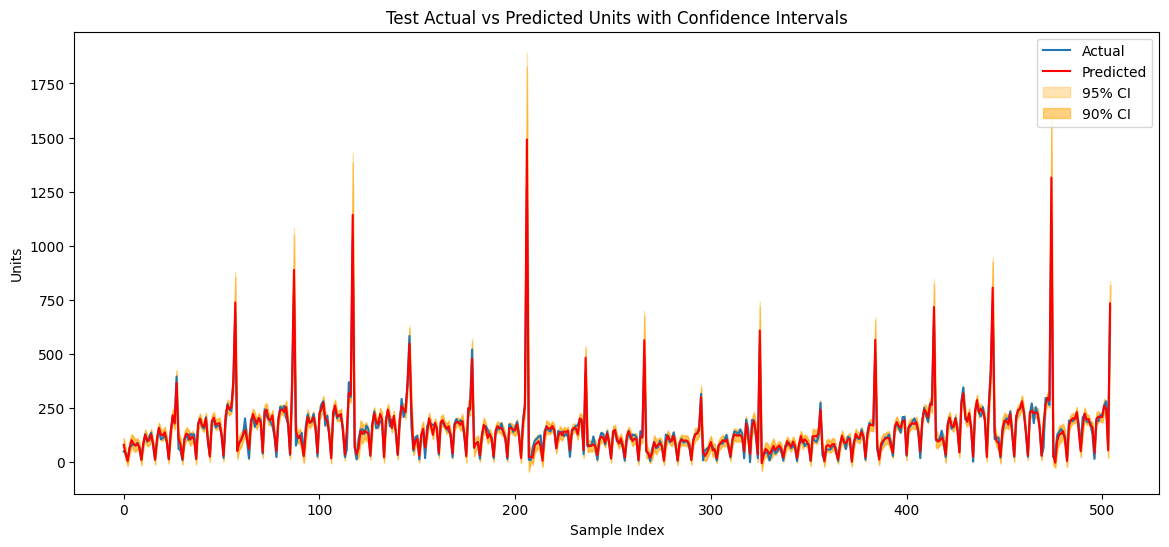

In [7]:
x_axis = np.arange(len(actuals_inv))

plt.figure(figsize=(14, 6))
plt.plot(actuals_inv[:, 0], label='Actual')
plt.plot(mu_preds_inv[:, 0], label='Predicted', color='red')
plt.fill_between(x_axis, lower_95_inv[:, 0], upper_95_inv[:, 0],
                 color='orange', alpha=0.3, label='95% CI')
plt.fill_between(x_axis, lower_90_inv[:, 0], upper_90_inv[:, 0],
                 color='orange', alpha=0.5, label='90% CI')
plt.title('Test Actual vs Predicted Units with Confidence Intervals')
plt.xlabel('Sample Index')
plt.ylabel('Units')
plt.legend()
plt.show()

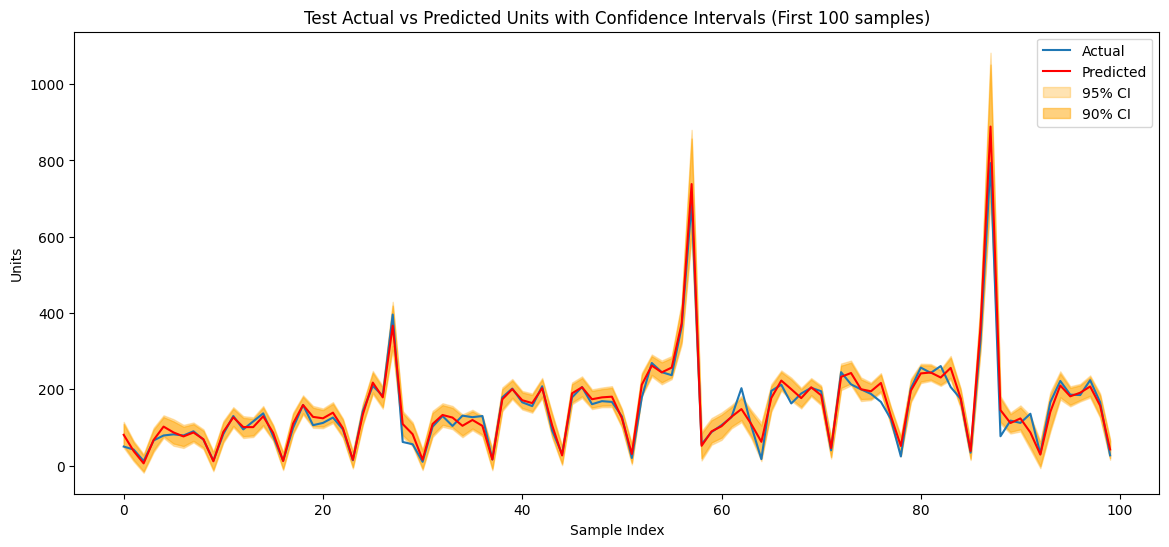

In [8]:
# Vẽ từng 100 sample đầu tiên cho Units
plt.figure(figsize=(14, 6))
plt.plot(actuals_inv[:100, 0], label='Actual')
plt.plot(mu_preds_inv[:100, 0], label='Predicted', color='red')
plt.fill_between(np.arange(100), lower_95_inv[:100, 0], upper_95_inv[:100, 0],
				 color='orange', alpha=0.3, label='95% CI')
plt.fill_between(np.arange(100), lower_90_inv[:100, 0], upper_90_inv[:100, 0],
				 color='orange', alpha=0.5, label='90% CI')
plt.title('Test Actual vs Predicted Units with Confidence Intervals (First 100 samples)')
plt.xlabel('Sample Index')
plt.ylabel('Units')
plt.legend()
plt.show()

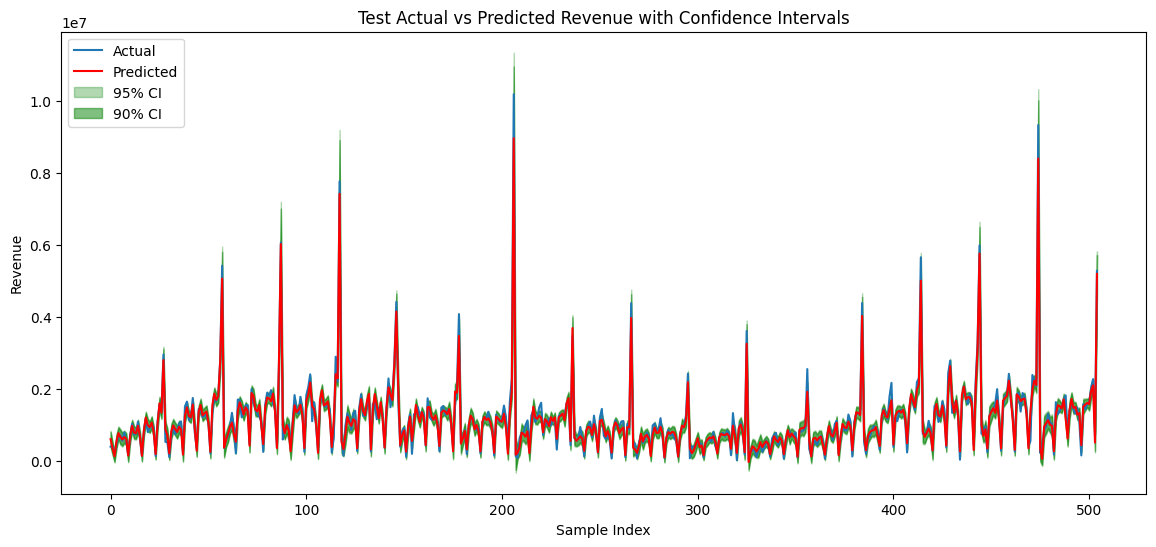

In [9]:
plt.figure(figsize=(14, 6))
plt.plot(actuals_inv[:, 1], label='Actual')
plt.plot(mu_preds_inv[:, 1], label='Predicted', color='red')
plt.fill_between(x_axis, lower_95_inv[:, 1], upper_95_inv[:, 1],
                 color='green', alpha=0.3, label='95% CI')
plt.fill_between(x_axis, lower_90_inv[:, 1], upper_90_inv[:, 1],
                 color='green', alpha=0.5, label='90% CI')
plt.title('Test Actual vs Predicted Revenue with Confidence Intervals')
plt.xlabel('Sample Index')
plt.ylabel('Revenue')
plt.legend()
plt.show()

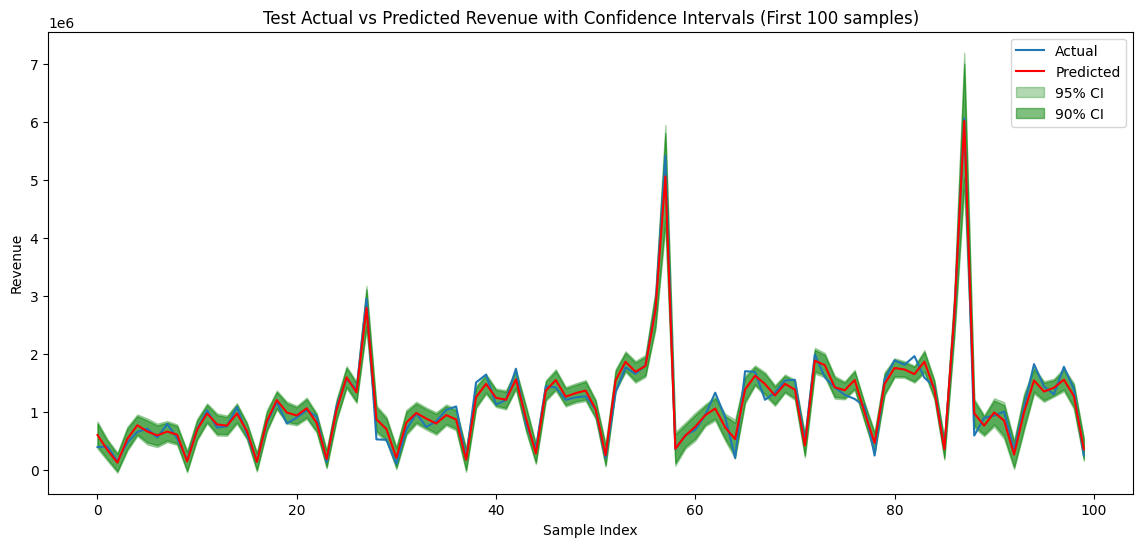

In [10]:
# Vẽ từng 100 sample đầu tiên cho Revenue
plt.figure(figsize=(14, 6))
plt.plot(actuals_inv[:100, 1], label='Actual')
plt.plot(mu_preds_inv[:100, 1], label='Predicted', color='red')
plt.fill_between(np.arange(100), lower_95_inv[:100, 1], upper_95_inv[:100, 1],
				 color='green', alpha=0.3, label='95% CI')
plt.fill_between(np.arange(100), lower_90_inv[:100, 1], upper_90_inv[:100, 1],
				 color='green', alpha=0.5, label='90% CI')
plt.title('Test Actual vs Predicted Revenue with Confidence Intervals (First 100 samples)')
plt.xlabel('Sample Index')
plt.ylabel('Revenue')
plt.legend()
plt.show()